### Training a 3 layer bidirectional LSTM on twitter dataset with 1.5 million tweets

#### Test set error rate, training time, and epochs.

- Error rate: 14.35%
- Training time: 207 minutes
- Epochs: 5 epochs

#### Learning schedule
- 1.531 initial learning rate
- Divided by 1.4 every 2 epochs
- Quadruple batch size in epoch 4

#### Hyperparameters
- Initial batch size 125
- Quadrupled batch size to 500 in epoch 4
- Hidden layer size 421

# ----------------------------------------------------------------------------------

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import utils
import time

In [22]:
device= torch.device("cuda")
print(device)

cuda


In [23]:
train_data = torch.load('../data/twitter/train_data.pt')
train_label = torch.load('../data/twitter/train_label.pt')
test_data = torch.load('../data/twitter/test_data.pt')
test_label = torch.load('../data/twitter/test_label.pt')

print('num review in train = ', len(train_data))
print('num review in test = ', len(test_data))

num review in train =  1428612
num review in test =  150000


In [24]:
class rec_neural_net(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, output_size, num_layers):
        super().__init__()
        
        self.emb_layer = nn.Embedding(vocab_size, hidden_size)
        self.rec_layer = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True)
        self.lin_layer = nn.Linear(hidden_size*2, output_size)
        
        
    def forward(self, input_seq):
        
        input_seq_emb = self.emb_layer( input_seq )
    
        output_seq , (h_last, c_last) = self.rec_layer( input_seq_emb )
        
        h_direc_1  = h_last[2,:,:]
        h_direc_2  = h_last[3,:,:]
        h_direc_12 = torch.cat( (h_direc_1, h_direc_2)  , dim=1) 
        
        scores = self.lin_layer( h_direc_12 )
            
        return scores

In [25]:
vocab_size = 30002
num_layers = 3
hid_size= 421
out_size= 2

net=rec_neural_net(vocab_size,hid_size, out_size, num_layers)
net = net.to(device)

print(net)
utils.display_num_param(net)

rec_neural_net(
  (emb_layer): Embedding(30002, 421)
  (rec_layer): LSTM(421, 421, num_layers=3, bidirectional=True)
  (lin_layer): Linear(in_features=842, out_features=2, bias=True)
)
There are 23996160 (24.00 million) parameters in this neural network


In [26]:
criterion = nn.CrossEntropyLoss()
my_lr = 1.531
bs = 125

In [27]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    with torch.no_grad():

        for i in range(0,150000-bs,bs):
        
            # extract the minibatch
            indices = torch.arange(i,i+bs)             
            minibatch_data, minibatch_label =  utils.make_minibatch(indices, test_data, test_label) 
                
            # send to GPU    
            minibatch_data = minibatch_data.to(device)
            minibatch_label = minibatch_label.to(device) 
            
            # feed it to the network
            scores=net(minibatch_data) 

            # compute the error made on this batch
            error = utils.get_error( scores , minibatch_label)

            # add it to the running error
            running_error += error.item()

            num_batches+=1

    # compute error rate on the full test set
    total_error = running_error/num_batches

    print( 'error rate on test set =', total_error*100 ,'percent')

In [28]:
start=time.time()

for epoch in range(8):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(1428612)

    if epoch==2:
            my_lr = my_lr / 1.4
    if epoch==4:
            my_lr = my_lr / 1.4
            bs = bs*4
    if epoch==6:
            my_lr = my_lr / 1.4
            
    for count in range(0,1428612-bs,bs):
      
        # Set the gradients to zeros
        optimizer = optim.SGD(net.parameters(), lr=my_lr)
        optimizer.zero_grad()
        
        # get the minibatch
        indices = shuffled_indices[count:count+bs]
        minibatch_data, minibatch_label =  utils.make_minibatch(indices, train_data, train_label) 
            
        # send to GPU    
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)            

        # forward the minibatch through the net        
        scores = net( minibatch_data ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dW, dL/dR etc...   
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), 5)

        # do one step of stochastic gradient descent
        optimizer.step()
        
        # computing stats
        num_batches+=1
        with torch.no_grad():
            running_loss += loss.item()
            error = utils.get_error( scores , minibatch_label)
            running_error += error.item()

        if (count)/500000 == 1:
            elapsed = (time.time()-start)/60
            r_elapsed = round(elapsed,6)
            r_lr = round(my_lr,3)
            r_loss = round(running_loss/num_batches, 5)
            r_error = round(100*running_error/num_batches,6)
            print('epoch =',epoch, '.35', '| time =', r_elapsed, '| lr =', r_lr,'| loss =', r_loss , '| error =', r_error ,'%') 
        if (count)/1000000 == 1:
            elapsed = (time.time()-start)/60
            r_elapsed = round(elapsed,6)
            r_lr = round(my_lr,3)
            r_loss = round(running_loss/num_batches, 5)
            r_error = round(100*running_error/num_batches,6)
            print('epoch =',epoch, '.70', '| time =', r_elapsed, '| lr =', r_lr,'| loss =', r_loss , '| error =', r_error ,'%')
            
    # epoch finished:  compute and display stats for the full training set
    elapsed = (time.time()-start)/60
    r_elapsed = round(elapsed,6)
    r_lr = round(my_lr,3)
    r_loss = round(running_loss/num_batches, 5)
    r_error = round(100*running_error/num_batches,6)
    print('epoch =',epoch+1, '.00', '| time =', r_elapsed, '| lr =', r_lr, '| loss =', r_loss , '| error =', r_error ,'%')
    
    # compute error on the test set:
    eval_on_test_set() 
    print(" ")

epoch = 0 .35 | time = 14.369831 | lr = 1.531 | loss = 0.47562 | error = 22.422791 %
epoch = 0 .70 | time = 28.754237 | lr = 1.531 | loss = 0.43017 | error = 19.845116 %
epoch = 1 .00 | time = 41.085582 | lr = 1.531 | loss = 0.41065 | error = 18.737133 %
error rate on test set = 15.812506215387428 percent
 
epoch = 1 .35 | time = 56.891099 | lr = 1.531 | loss = 0.33868 | error = 14.788499 %
epoch = 1 .70 | time = 71.310744 | lr = 1.531 | loss = 0.33752 | error = 14.740453 %
epoch = 2 .00 | time = 83.601598 | lr = 1.531 | loss = 0.33602 | error = 14.661459 %
error rate on test set = 15.048536238220953 percent
 
epoch = 2 .35 | time = 99.388721 | lr = 1.094 | loss = 0.29565 | error = 12.639036 %
epoch = 2 .70 | time = 113.801382 | lr = 1.094 | loss = 0.29811 | error = 12.738203 %
epoch = 3 .00 | time = 126.092387 | lr = 1.094 | loss = 0.29955 | error = 12.801536 %
error rate on test set = 14.541446879269978 percent
 
epoch = 3 .35 | time = 141.904376 | lr = 1.094 | loss = 0.2712 | error 

# ----------------------------------------------------------------------------------

### Inference

* Choose at random a tweet in the test set
* Print the tweet in english 
* Print the label associated with this tweet
* Feed the tweet to the network
* provide a visual display of what the network predict (ex: 20% negative and 80% positive) 

RAND_INT: 101734
TWEET: everything was just great ... delicious , presentable & amp ; satisfying .
LABEL: tensor(1)


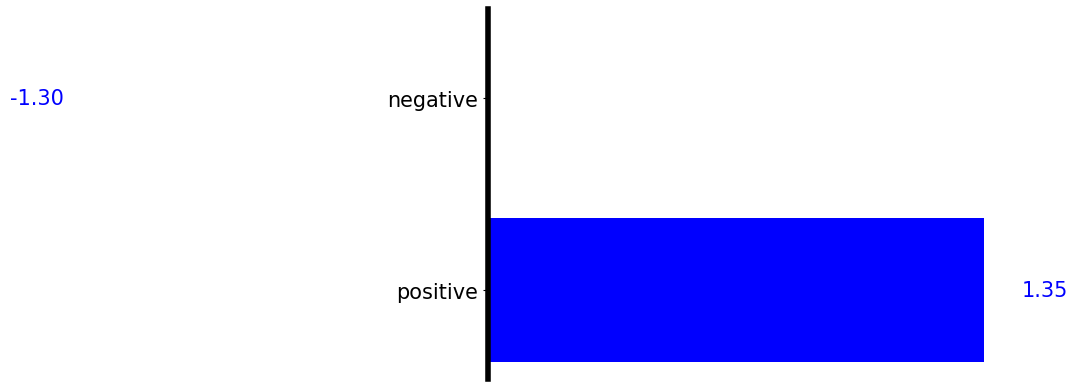

In [29]:
from random import randint

i = randint(0,150000)
print('RAND_INT:',i)
print('TWEET:', utils.tensor2text(test_data[i]) )
print('LABEL:' , test_label[i] )

tweet = test_data[i].to(device)
label = test_label[i].to(device)

p = net(tweet.unsqueeze(1))
utils.show_prob(p)

#### Write some ooriginal tweets
* print the tweet
* Use text2tensor() to print the associated LongTensor. Check everything is fine and you do not have to many "unknown" (coresponding to a 0). Recall that you must detach words and punctuation. For example "I am really happy!" should be written "I am really happy !".
* Feed the tweet to the network
* provide a visual display of what the network predict (ex: 20% negative and 80% positive) 

TWEET: tensor([   7,  384,   35,   39, 2139,   34, 4500,    8,   11,    7, 1006,   34,
          36,  121])


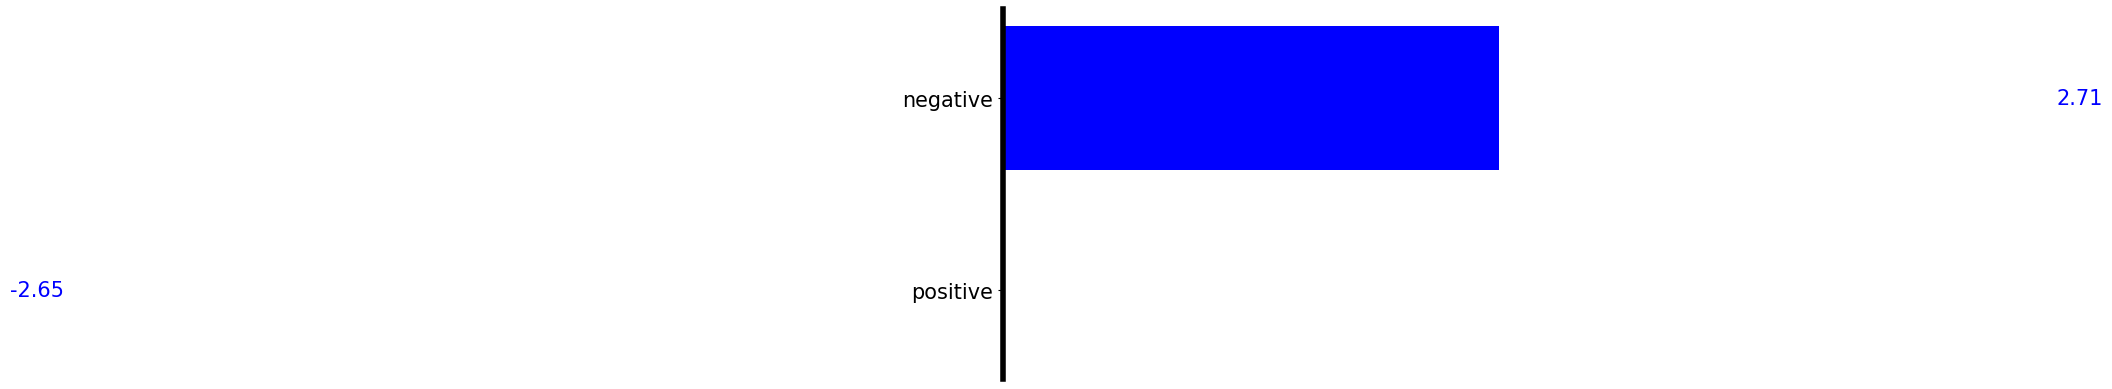

In [31]:
tweet = utils.text2tensor("The food at this restaurant was average , and the service was not great")
print('TWEET:', tweet )
tweet = tweet.to(device)

p = net(tweet.unsqueeze(1))
utils.show_prob(p)    

TWEET: tensor([   2, 6654,  395,    2,  260,   10, 3005,   17,    7, 4412,    3])


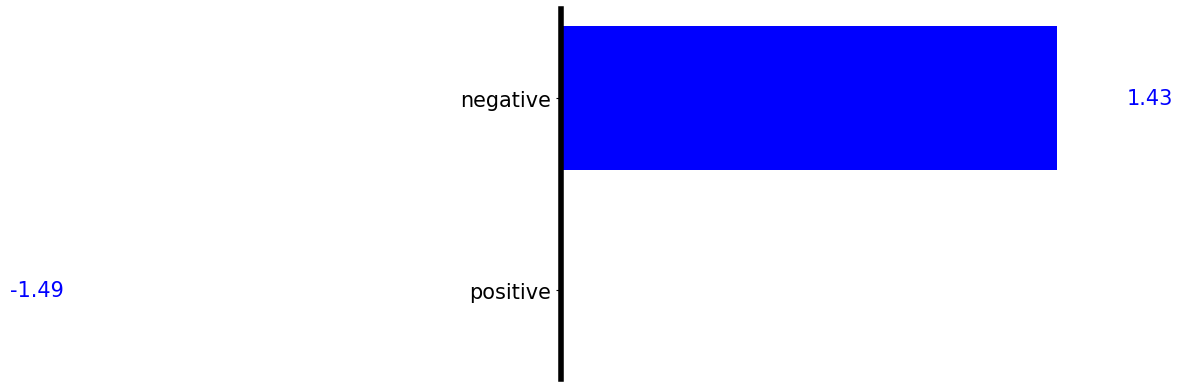

In [32]:
tweet = utils.text2tensor("I cannot believe I left my wallet in the taxi !")
print('TWEET:', tweet )
tweet = tweet.to(device)

p = net(tweet.unsqueeze(1))
utils.show_prob(p)    

TWEET: tensor([   2,   25,    7, 2120, 1179,   18,    7, 5050,   27,    2, 6654,  224,
          12])


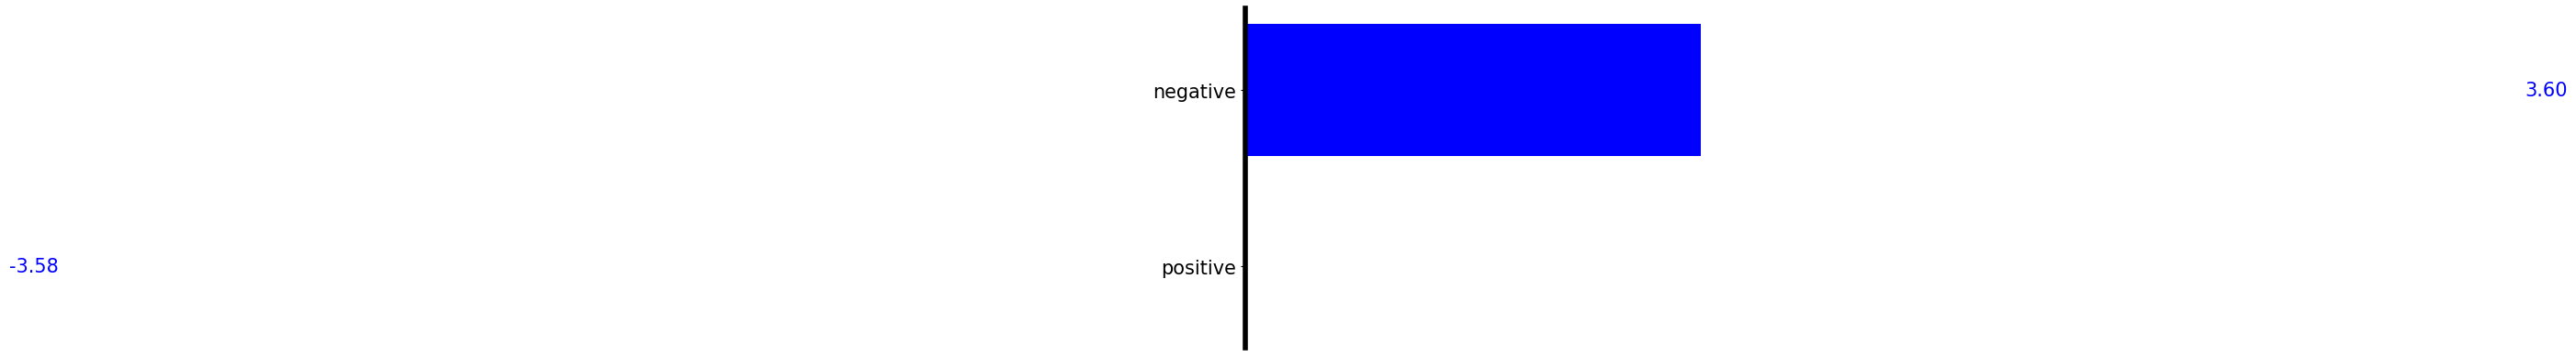

In [33]:
tweet = utils.text2tensor("I have the winning ticket for the lottery but I cannot find it")
print('TWEET:', tweet )
tweet = tweet.to(device)

p = net(tweet.unsqueeze(1))
utils.show_prob(p)    

TWEET: tensor([   2,   30,  720,    9,   76, 1420,  899,    8,   85,  174, 8371,   32,
           0,    4,    2,   70,  148,   65,    5,   39, 2139,    4])


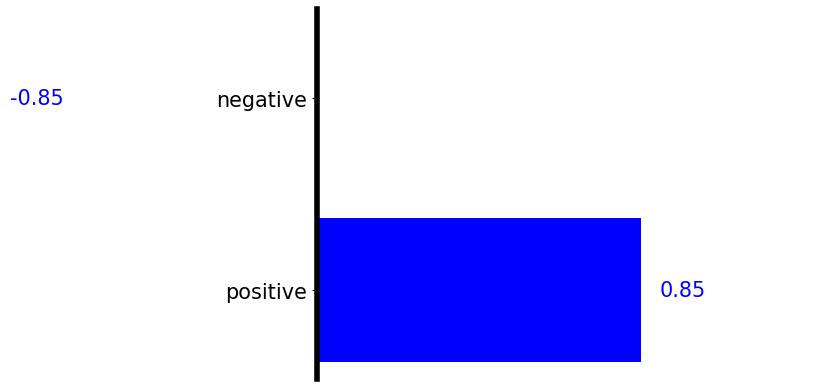

In [34]:
tweet = utils.text2tensor("I just ate a really delicious pizza , they were generous with toppings . I will come back to this restaurant .")
print('TWEET:', tweet )
tweet = tweet.to(device)

p = net(tweet.unsqueeze(1))
utils.show_prob(p)    

### 